# Imports


In [1]:
import hashlib
import os
import re
import haiku as hk
import jax
import GPUtil
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import seaborn as sns

from copy import deepcopy
from pathlib import Path
from scipy.stats import spearmanr, pearsonr
from prody import parsePDB, Interactions, addMissingAtoms
from colabfold.batch import get_queries, run, set_model_type
from colabfold.colabfold import plot_protein
from colabfold.download import download_alphafold_params
from colabfold.plot import plot_msa_v2
from colabfold.utils import setup_logging
from tqdm.auto import tqdm
from alphafold.model import folding, modules
from alphafold.common import confidence

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = f"{GPUtil.getFirstAvailable(order='memory', attempts=5, interval=30)[0]}"

# Configuration


- Taken directly from the [Colabfold Notebook](https://github.com/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb)


## Input Settings


- B1 domain of Protein G according to [UniProt](https://www.rcsb.org/sequence/3GB1#A):
  > TYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE
- Protein G according to [UniProt](https://www.uniprot.org/uniprotkb/P06654/entry):
  > VDSPIEDTPIIRNGGELTNLLGNSETTLALRNEESATADLTAAAVADTVAAAAAENAGAAAWEAAAAADALAKAKADALKEFNKYGVSDYYKNLINNAKTVEGIKDLQAQVVESAKKARISEATDGLSDFLKSQTPAEDTVKSIELAEAKVLANRELDKYGVSDYHKNLINNAKTVEGVKELIDEILAALPKTDTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTEKPEVIDASELTPAVTTYKLVINGKTLKGETTTKAVDAETAEKAFKQYANDNGVDGVWTYDDATKTFTVTEMVTEVPGDAPTEPEKPEASIPLVPLTPATPIAKDDAKKDDTKKEDAKKPEAKKDDAKKAETLPTT
- Tendamistat according to [UniProt](https://www.rcsb.org/sequence/1OK0):
  > DTTVSEPAPSCVTLYQSWRYSQADNGCAQTVTVKVVYEDDTEGLCYAVAPGQITTVGDGYIGSHGHARYLARCL
- Sso10a from Sulfolobus solfataricus according to [UniProt](https://www.rcsb.org/sequence/1R7J)
  > MAKKKSKLEIIQAILEACKSGSPKTRIMYGANLSYALTGRYIKMLMDLEIIRQEGKQYMLTKKGEELLEDIRKFNEMRKNMDQLKEKINSVLSIRQ
- Hylin-a1 according to [UniProt](https://www.uniprot.org/uniprotkb/P85982/entry)
  > IFGAILPLALGALKNLIK
- Conantokin-T (Con-T) according to [UniProt](https://www.uniprot.org/uniprotkb/P17684/entry)
  > GEEEYQKMLENLREAEVKKNA
- Humanin (Humanin mitochondrial) (HNM) according to [UniProt](https://www.uniprot.org/uniprotkb/Q8IVG9/entry)
  > MAPRGFSCLLLLTSEIDLPVKRRA
- CMTI-I(TrypsinInhibitor1) according to [UniProt](https://www.uniprot.org/uniprotkb/P01074/entry)
  > RVCPRILMECKKDSDCLAECVCLEHGYCG
- Alpha-conotoxin RgIA according to [UniProt](https://www.uniprot.org/uniprotkb/P0C1D0/entry)
  > GCCSDPRCRYRCR
- PP according to [UniProt](https://www.uniprot.org/uniprotkb/P68249/entry)
  > GPSQPTYPGDDAPVEDLIRFYNDLQQYLNVVTRHRY
- EAFP2 according to [UniProt](https://www.uniprot.org/uniprotkb/P83597/entry)
  > QTCASRCPRPCNAGLCCSIYGYCGSGAAYCGAGNCRCQCRG
- Ferredoxin according to [UniProt](https://www.uniprot.org/uniprotkb/P00198/entry)
  > MAYVINEACISCGACEPECPVNAISSGDDRYVIDADTCIDCGACAGVCPVDAPVQA


In [3]:
# Use `:` to specify inter-protein chainbreaks for **modeling complexes** (supports homo- and hetro-oligomers). For example **PI...SK:PI...SK** for a homodimer
query_sequence = "TYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE"

protein_name = "B1"
# Name of the experiment
jobname = f"Attn_{protein_name}"

# Specify how many of the top ranked structures to relax using amber
num_relax = 0  # possible values - [0, 1, 5]

# Whether to use pdb100 templates or not
use_templates = False

# whether to use amber relaxation or not
use_amber = num_relax > 0

# remove whitespaces
query_sequence = "".join(query_sequence.split())

In [4]:
def add_hash(x, y):
    return x + "_" + hashlib.sha1(y.encode()).hexdigest()[:5]


basejobname = "".join(jobname.split())
basejobname = re.sub(r"\W+", "", basejobname)
jobname = add_hash(basejobname, query_sequence)

In [5]:
# check if directory with jobname exists
def check(folder):
    if os.path.exists(folder):
        return False
    else:
        return True


if not check(jobname):
    n = 0
    while not check(f"{jobname}_{n}"):
        n += 1
    jobname = f"{jobname}_{n}"

# make directory to save results
os.makedirs(jobname, exist_ok=True)

# save queries
queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as text_file:
    text_file.write(f"id,sequence\n{jobname},{query_sequence}")

In [6]:
print("jobname", jobname)
print("sequence", query_sequence)
print("length", len(query_sequence.replace(":", "")))

jobname Attn_B1_4c347
sequence TYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE
length 55


In [7]:
# MSA options - [single sequence, pairing mode]
# possible values - ["mmseqs2_uniref_env", "mmseqs2_uniref","single_sequence"]
msa_mode = "mmseqs2_uniref_env"

# "unpaired_paired" = pair sequences from same species + unpaired MSA,
# "unpaired" = seperate MSA for each chain,
# "paired" - only use paired sequences.
# possible values - ["unpaired_paired","paired","unpaired"] {type:"string"}
pair_mode = "unpaired_paired"


# decide which a3m to use
if "mmseqs2" in msa_mode:
    a3m_file = os.path.join(jobname, f"{jobname}.a3m")
else:
    a3m_file = os.path.join(jobname, f"{jobname}.single_sequence.a3m")
    with open(a3m_file, "w") as text_file:
        text_file.write(">1\n%s" % query_sequence)

## Advanced Settings


In [8]:
# possible values -
#     ["auto", "alphafold2_ptm", "alphafold2_multimer_v1",
#     "alphafold2_multimer_v2", "alphafold2_multimer_v3", "deepfold_v1"]
#
# If `auto` is selected, will use `alphafold2_ptm` for monomer prediction and
# `alphafold2_multimer_v3` for complex prediction.
# Any of the mode_types can be used (regardless if input is monomer or complex).
model_type = "auto"

# possible values - ["auto", "0", "1", "3", "6", "12", "24", "48"]
# If `auto` selected, will use `num_recycles=20` if
# `model_type=alphafold2_multimer_v3`, else `num_recycles=3` .
num_recycles = "3"

# possible values - ["auto", "0.0", "0.5", "1.0"]
# If `auto` is selected, will use `tol=0.5`
# if `model_type=alphafold2_multimer_v3` else `tol=0.0`.
recycle_early_stop_tolerance = "auto"

# possible values - [0, 200, 2000]
# Max amber relaxation iterations, `0` = unlimited (default, takes very long)
relax_max_iterations = 200

# possible values - ["greedy", "complete"]
# `greedy` = pair any taxonomically matching subsets,
# `complete` = all sequences have to match in one line.
pairing_strategy = "greedy"

In [9]:
# process config
num_recycles = None if num_recycles == "auto" else int(num_recycles)
recycle_early_stop_tolerance = (
    None
    if recycle_early_stop_tolerance == "auto"
    else float(recycle_early_stop_tolerance)
)

## Sampling settings


In [10]:
# Decrease `max_msa` to increase uncertainity
# possible values - ["auto", "512:1024", "256:512", "64:128", "32:64", "16:32"]
max_msa = "auto"

# Increase number of seeds to sample predictions from uncertainty of the model
# possible values - [1,2,4,8,16]
num_seeds = 1

# Whether to enable or disable dropouts
use_dropout = False

In [11]:
# process config
if max_msa == "auto":
    max_msa = None

## Save settings


In [12]:
save_all = True
save_recycles = False

# Set dpi for image resolution
dpi = 200

## Initial Setup


In [13]:
result_dir = jobname
log_filename = os.path.join(jobname, "log.txt")
setup_logging(Path(log_filename))

In [14]:
queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)

In [15]:
use_cluster_profile = not ("multimer" in model_type and max_msa is not None)

In [16]:
download_alphafold_params(model_type, Path("."))

In [17]:
def input_features_callback(input_features):
    plot_msa_v2(input_features)
    plt.show()
    plt.close()


def prediction_callback(
    protein_obj, length, prediction_result, input_features, mode
):
    model_name, relaxed = mode
    if not relaxed:
        fig = plot_protein(protein_obj, Ls=length, dpi=150)
        plt.show()
        plt.close()

# AlphaFold2 IG on Pair Representation


INFO:2025-01-02 22:11:49,948:jax._src.xla_bridge:927: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-01-02 22:11:49,952:jax._src.xla_bridge:927: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


2025-01-02 22:11:49,948 Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2025-01-02 22:11:49,952 Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2025-01-02 22:11:52,059 Running on GPU
2025-01-02 22:11:52,081 Found 5 citations for tools or databases
2025-01-02 22:11:52,081 Query 1/1: Attn_B1_4c347 (length 55)


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:00 remaining: 00:00]


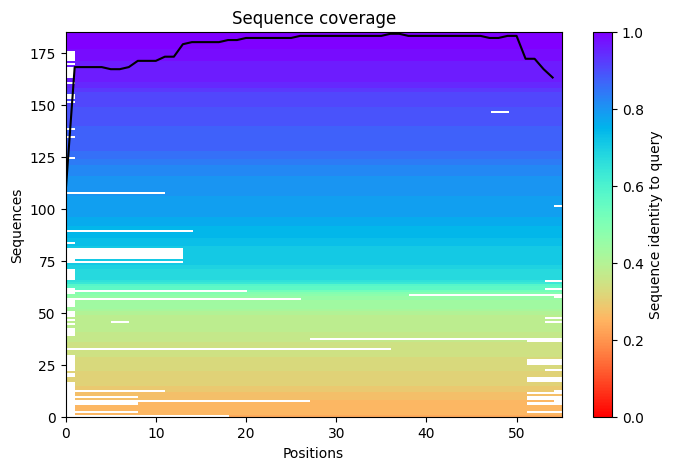

2025-01-02 22:11:53,273 Setting max_seq=185, max_extra_seq=1


I0000 00:00:1735855925.129050   35666 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


2025-01-02 22:12:33,423 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=94.3 pTM=0.743
2025-01-02 22:12:33,855 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=95.4 pTM=0.778 tol=0.146
2025-01-02 22:12:34,289 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=95.8 pTM=0.788 tol=0.0808
2025-01-02 22:12:34,720 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=96.2 pTM=0.791 tol=0.0407
2025-01-02 22:12:34,721 alphafold2_ptm_model_1_seed_000 took 29.4s (3 recycles)


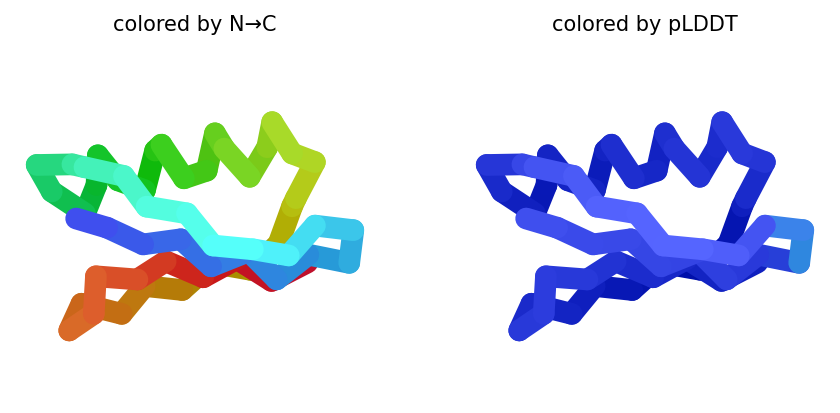

2025-01-02 22:12:35,233 alphafold2_ptm_model_2_seed_000 recycle=0 pLDDT=94.2 pTM=0.746
2025-01-02 22:12:35,664 alphafold2_ptm_model_2_seed_000 recycle=1 pLDDT=94.9 pTM=0.763 tol=0.0812
2025-01-02 22:12:36,096 alphafold2_ptm_model_2_seed_000 recycle=2 pLDDT=95.5 pTM=0.776 tol=0.0488
2025-01-02 22:12:36,529 alphafold2_ptm_model_2_seed_000 recycle=3 pLDDT=96.4 pTM=0.794 tol=0.0359
2025-01-02 22:12:36,530 alphafold2_ptm_model_2_seed_000 took 1.7s (3 recycles)


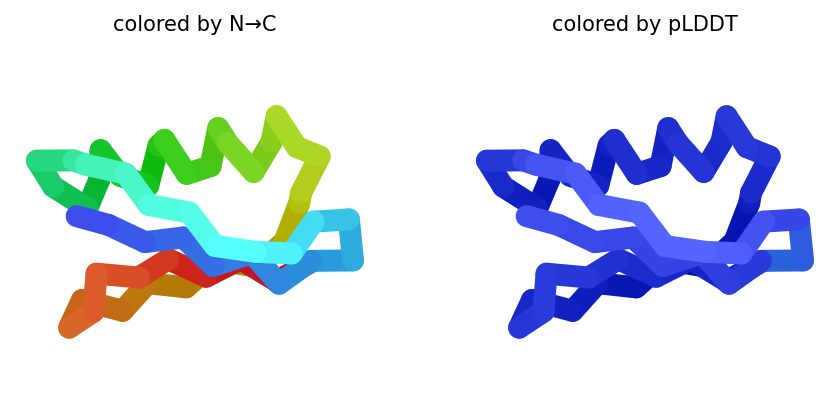

2025-01-02 22:12:37,041 alphafold2_ptm_model_3_seed_000 recycle=0 pLDDT=94.2 pTM=0.737
2025-01-02 22:12:37,471 alphafold2_ptm_model_3_seed_000 recycle=1 pLDDT=94.7 pTM=0.754 tol=0.1
2025-01-02 22:12:37,902 alphafold2_ptm_model_3_seed_000 recycle=2 pLDDT=94.5 pTM=0.749 tol=0.0547
2025-01-02 22:12:38,332 alphafold2_ptm_model_3_seed_000 recycle=3 pLDDT=94.8 pTM=0.754 tol=0.0303
2025-01-02 22:12:38,333 alphafold2_ptm_model_3_seed_000 took 1.7s (3 recycles)


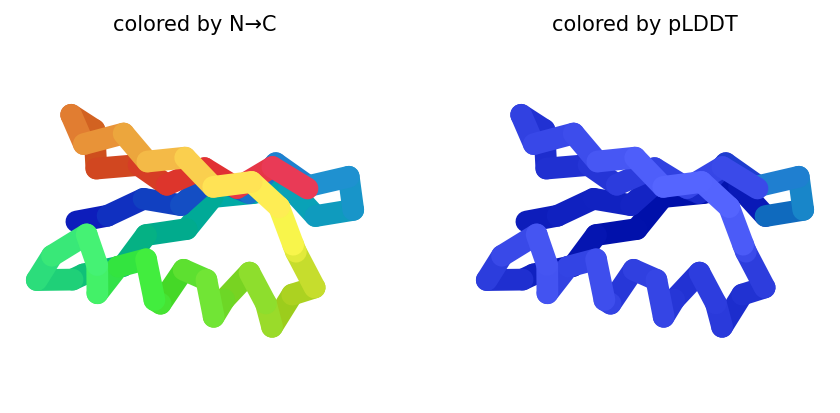

2025-01-02 22:12:38,844 alphafold2_ptm_model_4_seed_000 recycle=0 pLDDT=95.1 pTM=0.753
2025-01-02 22:12:39,274 alphafold2_ptm_model_4_seed_000 recycle=1 pLDDT=95.1 pTM=0.761 tol=0.148
2025-01-02 22:12:39,704 alphafold2_ptm_model_4_seed_000 recycle=2 pLDDT=95.4 pTM=0.768 tol=0.0522
2025-01-02 22:12:40,136 alphafold2_ptm_model_4_seed_000 recycle=3 pLDDT=95.8 pTM=0.775 tol=0.0338
2025-01-02 22:12:40,136 alphafold2_ptm_model_4_seed_000 took 1.7s (3 recycles)


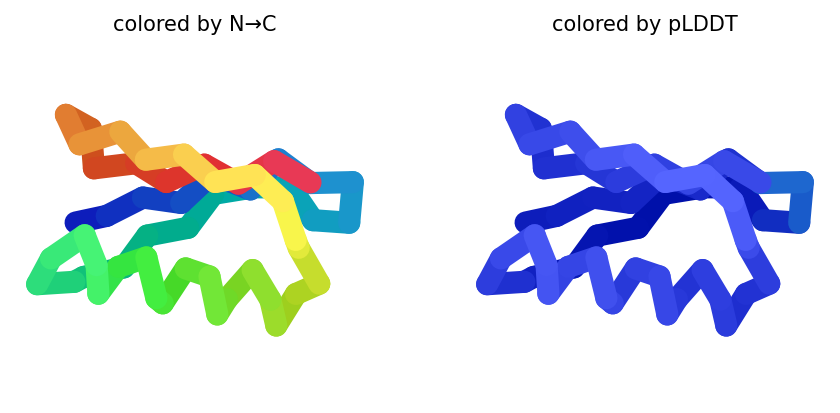

2025-01-02 22:12:40,652 alphafold2_ptm_model_5_seed_000 recycle=0 pLDDT=95.2 pTM=0.763
2025-01-02 22:12:41,084 alphafold2_ptm_model_5_seed_000 recycle=1 pLDDT=96.2 pTM=0.796 tol=0.115
2025-01-02 22:12:41,517 alphafold2_ptm_model_5_seed_000 recycle=2 pLDDT=96.6 pTM=0.801 tol=0.0787
2025-01-02 22:12:41,952 alphafold2_ptm_model_5_seed_000 recycle=3 pLDDT=97.1 pTM=0.81 tol=0.0492
2025-01-02 22:12:41,953 alphafold2_ptm_model_5_seed_000 took 1.7s (3 recycles)


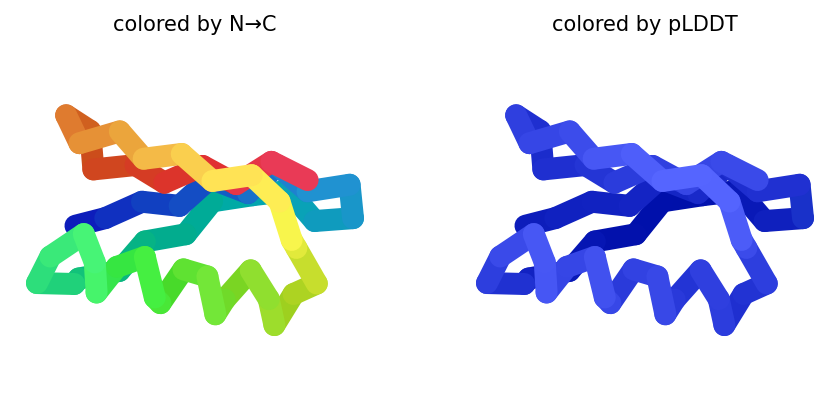

2025-01-02 22:12:42,037 reranking models by 'plddt' metric
2025-01-02 22:12:42,037 rank_001_alphafold2_ptm_model_5_seed_000 pLDDT=97.1 pTM=0.81
2025-01-02 22:12:42,037 rank_002_alphafold2_ptm_model_2_seed_000 pLDDT=96.4 pTM=0.794
2025-01-02 22:12:42,038 rank_003_alphafold2_ptm_model_1_seed_000 pLDDT=96.2 pTM=0.791
2025-01-02 22:12:42,038 rank_004_alphafold2_ptm_model_4_seed_000 pLDDT=95.8 pTM=0.775
2025-01-02 22:12:42,038 rank_005_alphafold2_ptm_model_3_seed_000 pLDDT=94.8 pTM=0.754
2025-01-02 22:12:43,248 Done


In [18]:
results = run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=None,
    num_relax=num_relax,
    msa_mode=msa_mode,
    model_type=model_type,
    num_models=5,
    num_recycles=num_recycles,
    relax_max_iterations=relax_max_iterations,
    recycle_early_stop_tolerance=recycle_early_stop_tolerance,
    num_seeds=num_seeds,
    use_dropout=use_dropout,
    model_order=[1, 2, 3, 4, 5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode=pair_mode,
    pairing_strategy=pairing_strategy,
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=dpi,
    zip_results=False,
    save_all=save_all,
    max_msa=max_msa,
    use_cluster_profile=use_cluster_profile,
    input_features_callback=input_features_callback,
    save_recycles=save_recycles,
    user_agent="colabfold/google-colab-main",
    use_bfloat16=False,
)

## Define Gradient Function in Jax


In [19]:
# List of tuples, each tuple with the following entries:
# 1. Model name
# 2. Model Instance
# 3. Model Parameters
model_runner_and_params = results["locals"]["model_runner_and_params"]

# Choose the first model for prototyping
model_name, model_runner, model_params = model_runner_and_params[0]
model_runner.params = model_params  # replace with correct parameters

# Get input features for the given protein sequence
feature_dict = results["locals"]["feature_dict"]
input_features = model_runner.process_features(feature_dict, random_seed=0)
r = input_features["aatype"].shape[0]
input_features["asym_id"] = np.tile(feature_dict["asym_id"], r).reshape(r, -1)
single_iter_input_features = jax.tree.map(lambda x: x[0:1], input_features)

In [20]:
key = jax.random.PRNGKey(0)

In [21]:
relevant_params = {}
for param_name, value in tqdm(model_params.items()):
    if ("structure_module" in param_name) or (
        "predicted_lddt_head" in param_name
    ) or ("evoformer" in param_name):
        _, _, relevant_name = param_name.split("/", maxsplit=2)
        relevant_params[relevant_name] = value

  0%|          | 0/109 [00:00<?, ?it/s]

In [22]:
def evoformer_fn(batch, is_training):
    if batch["aatype"].ndim == 2:
        batch = jax.tree.map(lambda x: x[0], batch)
    L = batch['aatype'].shape[0]
    prev = {'prev_msa_first_row': jnp.zeros([L, 256]),
            'prev_pair': jnp.zeros([L, L, 128]),
            'prev_pos': jnp.zeros([L, 37, 3])}
    batch = {**batch, **prev}
    evoformer_module = modules.EmbeddingsAndEvoformer(
        model_runner.config.model.embeddings_and_evoformer,
        model_runner.config.model.global_config,
    )
    representations = evoformer_module(batch, is_training)
    return representations, batch, is_training


evoformer_fn = hk.transform(evoformer_fn)

In [23]:
representations, batch, is_training = evoformer_fn.apply(
    relevant_params, key, input_features, False
)

In [24]:
def forward_fn(pair, single, msa, msa_first_row, batch, is_training):
    representations = {
        "single": single,
        "pair": pair,
        "msa": msa,
        "msa_first_row": msa_first_row
    }
    structure_module = folding.StructureModule(
        model_runner.config.model.heads.structure_module,
        model_runner.config.model.global_config,
        compute_loss=False,
    )
    sm_output = structure_module(representations, batch, is_training)
    plddt_module = modules.PredictedLDDTHead(
        model_runner.config.model.heads.predicted_lddt,
        model_runner.config.model.global_config,
    )
    representations.update(sm_output.pop("representations"))
    logits = plddt_module(representations, batch, is_training)['logits']
    plddt = confidence.compute_plddt(logits, use_jnp=True)
    return jnp.mean(plddt)


forward_fn = hk.transform(forward_fn)

In [25]:
grad_fn = jax.grad(forward_fn.apply, argnums=2)

## Integrated Gradients with Pair Representation


In [26]:
def IG_pair_representation(
    grad_model_fn,
    model_params,
    representations,
    batch,
    is_training,
    N,
    reference="zero",
):

    pair = deepcopy(representations['pair'])
    single = representations['single']
    msa = representations['msa']
    msa_first_row = representations['msa_first_row']
    if reference.lower() == "zero":
        baseline = jnp.zeros_like(representations['pair'])
    else:
        raise NotImplementedError

    ig_output = jnp.zeros_like(pair)
    for i in tqdm(range(N), total=N):
        pair = baseline + (representations['pair'] - baseline) * i / N
        output = grad_model_fn(
            model_params, key, pair, single, msa,
            msa_first_row, batch, is_training
        )
        ig_output += output
    ig_output = (representations['pair'] - baseline)*ig_output
    return np.squeeze(np.asanyarray(ig_output / N))

In [27]:
ig_output = IG_pair_representation(
    grad_fn, relevant_params, representations, batch, is_training, 20
)

  0%|          | 0/20 [00:00<?, ?it/s]

In [28]:
ig_importances = jnp.linalg.norm(ig_output, axis=-1)
ig_importances = ig_importances/np.linalg.norm(ig_importances)  # normalize

In [29]:
char2peptide = {
    'C': 'CYS',
    'D': 'ASP',
    'S': 'SER',
    'Q': 'GLN',
    'K': 'LYS',
    'I': 'ILE',
    'P': 'PRO',
    'T': 'THR',
    'F': 'PHE',
    'N': 'ASN',
    'G': 'GLY',
    'H': 'HIS',
    'L': 'LEU',
    'R': 'ARG',
    'W': 'TRP',
    'A': 'ALA',
    'V': 'VAL',
    'E': 'GLU',
    'Y': 'TYR',
    'M': 'MET'
}
labels = [
    f'{char2peptide[b].title()}{a}'
    for (a, b) in enumerate(query_sequence, start=1)
]

Text(0.5, 1.0, 'Pair-wise Attention')

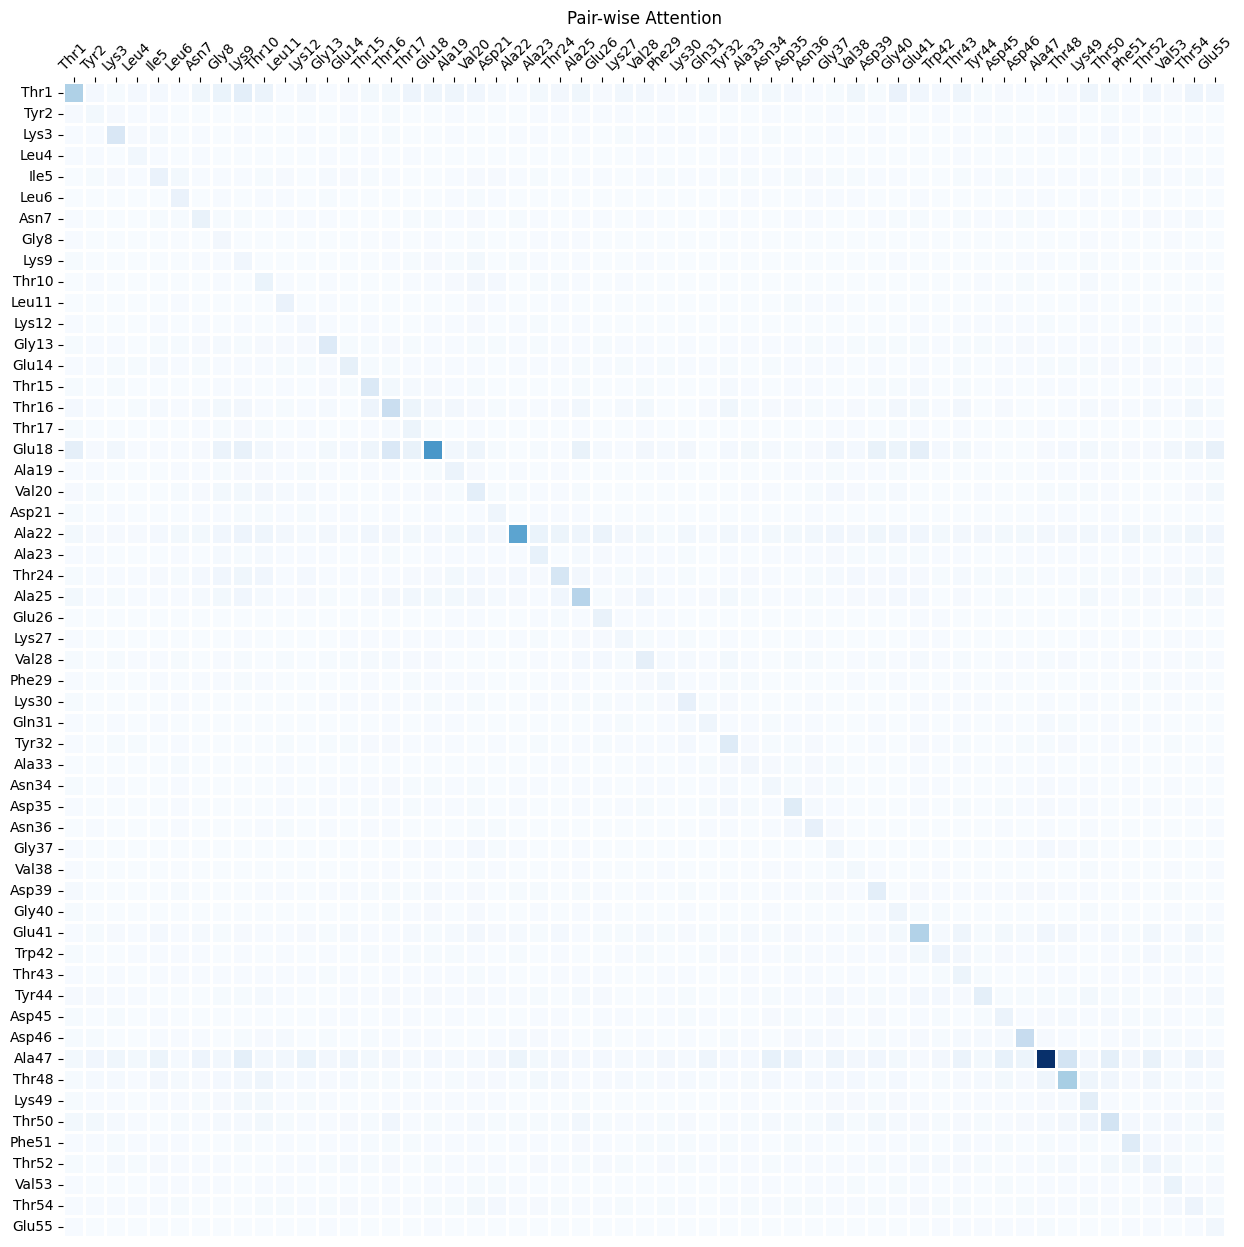

In [30]:
if protein_name == 'Sso10a':
    plt.figure(figsize=(25, 25))  # only for Sso10a
else:
    plt.figure(figsize=(15, 15))  # for the rest
ax = sns.heatmap(
    ig_importances, cbar=False, xticklabels=labels,
    yticklabels=labels, linewidths=2, cmap='Blues'
)
ax.tick_params(
    top=True, labeltop=True, bottom=False, labelbottom=False,
)
if protein_name == 'Sso10a':
    ax.tick_params(axis='x', rotation=60)  # only for Sso10a
else:
    ax.tick_params(axis='x', rotation=45)  # for the rest
ax.set_title("Pair-wise Attention")

# Correlate Attention Scores with Interaction Energies


## Add missing atoms

- Needed when first running for Con-T, Humanin, PP, Sso10a


In [ ]:
if (protein_name in ['PP', 'H|umanin', 'Sso10a', 'Con-T']):
    addMissingAtoms(
        f"PDB/{protein_name}.pdb", method='pdbfixer',
        keep_waters=False, overwrite=True
    )

In [32]:
if (protein_name in ['PP', 'Humanin', 'Sso10a', 'Con-T']):
    coords = parsePDB(f"PDB/addH_{protein_name}.pdb")
else:
    coords = parsePDB(f"PDB/{protein_name}.pdb")

if protein_name == 'Sso10a':
    coords = coords.chain_A  # Sso10a has two chains
interactions = Interactions()

OSError: PDB/B1.pdb is not a valid filename or a valid PDB identifier.

In [33]:
all_interactions = interactions.calcProteinInteractions(coords)

@> Calculating interations.
@> Calculating hydrogen bonds.


2024-12-31 01:42:24,402 Calculating interations.
2024-12-31 01:42:24,473 Calculating hydrogen bonds.


@>      DONOR (res chid atom)   <--->       ACCEPTOR (res chid atom)    Distance  Angle
@>      SER21    A        OG_329  <--->      ALA16    A         O_266     2.4    30.8
@>      TYR40    A         N_622  <--->      THR37    A         O_580     2.4    37.4
@>      ARG77    A        N_1271  <--->      PHE73    A        O_1208     2.4    11.8
@>      LYS84    A        N_1396  <--->      MET80    A        O_1334     2.4    14.7
@>      ARG39    A         N_598  <--->      LEU36    A         O_561     2.4    23.8
@>      LEU83    A        N_1377  <--->      ASN79    A        O_1320     2.5    14.1
@>      ASP46    A         N_737  <--->      LYS42    A         O_665     2.7    17.5
@>      MET58    A         N_944  <--->      ARG51    A         O_824     2.7     4.9
@>      MET80    A        N_1331  <--->      MET76    A        O_1257     2.7    16.3
@>      GLU75    A        N_1239  <--->      ARG71    A        O_1162     2.8    27.4
@>      GLY29    A         N_466  <--->      ILE26  

2024-12-31 01:42:24,764      DONOR (res chid atom)   <--->       ACCEPTOR (res chid atom)    Distance  Angle
2024-12-31 01:42:24,765      SER21    A        OG_329  <--->      ALA16    A         O_266     2.4    30.8
2024-12-31 01:42:24,766      TYR40    A         N_622  <--->      THR37    A         O_580     2.4    37.4
2024-12-31 01:42:24,766      ARG77    A        N_1271  <--->      PHE73    A        O_1208     2.4    11.8
2024-12-31 01:42:24,767      LYS84    A        N_1396  <--->      MET80    A        O_1334     2.4    14.7
2024-12-31 01:42:24,768      ARG39    A         N_598  <--->      LEU36    A         O_561     2.4    23.8
2024-12-31 01:42:24,769      LEU83    A        N_1377  <--->      ASN79    A        O_1320     2.5    14.1
2024-12-31 01:42:24,769      ASP46    A         N_737  <--->      LYS42    A         O_665     2.7    17.5
2024-12-31 01:42:24,770      MET58    A         N_944  <--->      ARG51    A         O_824     2.7     4.9
2024-12-31 01:42:24,771      MET80 

/home/exouser/.pyenv/versions/3.10.16/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
@> Number of detected Pi stacking interactions: 0.
@> Calculating cation-Pi interactions.
@> Number of detected cation-pi interactions: 0.


2024-12-31 01:42:30,338 Number of detected Pi stacking interactions: 0.
2024-12-31 01:42:30,343 Calculating cation-Pi interactions.
2024-12-31 01:42:30,476 Number of detected cation-pi interactions: 0.


@> Hydrophobic Overlapping Areas are computed.
@> Calculating hydrophobic interactions.


2024-12-31 01:42:30,560 Hydrophobic Overlapping Areas are computed.
2024-12-31 01:42:30,562 Calculating hydrophobic interactions.


@>      MET45    A        SD_72614s  <--->      ILE50    A       CG2_808     3.4    27.3
@>      TYR57    A       CE1_93114s  <--->      MET45    A        CE_727     3.5    15.3
@>      LEU44    A       CD1_70714s  <--->      ILE13    A       CG2_216     3.5    11.0
@>      LEU32    A       CD2_50414s  <--->      ILE26    A       CG2_415     3.5    17.3
@>      MET58    A        CG_94914s  <--->      LEU59    A       CD2_968     3.6    57.8
@>      TYR40    A       CE2_63114s  <--->       ILE9    A       CG2_151     3.6    18.7
@>      LYS23    A        CG_35414s  <--->      ILE41    A       CD1_650     3.6    12.8
@>      ILE49    A       CG2_78914s  <--->      LEU14    A       CD2_236     3.7    25.7
@>      ALA16    A        CB_26714s  <--->      ILE26    A       CG1_414     3.8    15.5
@>      PHE73    A      CE1_121314s  <--->      ARG77    A       CG_1276     3.8    49.4
@>      TYR34    A       CE1_53514s  <--->      ALA35    A        CB_552     3.8    64.6
@>      ILE10    A   

2024-12-31 01:42:36,083      MET45    A        SD_72614s  <--->      ILE50    A       CG2_808     3.4    27.3
2024-12-31 01:42:36,084      TYR57    A       CE1_93114s  <--->      MET45    A        CE_727     3.5    15.3
2024-12-31 01:42:36,085      LEU44    A       CD1_70714s  <--->      ILE13    A       CG2_216     3.5    11.0
2024-12-31 01:42:36,086      LEU32    A       CD2_50414s  <--->      ILE26    A       CG2_415     3.5    17.3
2024-12-31 01:42:36,087      MET58    A        CG_94914s  <--->      LEU59    A       CD2_968     3.6    57.8
2024-12-31 01:42:36,088      TYR40    A       CE2_63114s  <--->       ILE9    A       CG2_151     3.6    18.7
2024-12-31 01:42:36,088      LYS23    A        CG_35414s  <--->      ILE41    A       CD1_650     3.6    12.8
2024-12-31 01:42:36,089      ILE49    A       CG2_78914s  <--->      LEU14    A       CD2_236     3.7    25.7
2024-12-31 01:42:36,089      ALA16    A        CB_26714s  <--->      ILE26    A       CG1_414     3.8    15.5
2024-12-31

In [34]:
interaction_matrix = np.abs(interactions.buildInteractionMatrixEnergy(
    energy_list_type='IB_nosolv'))
interaction_matrix = interaction_matrix / \
    np.linalg.norm(interaction_matrix)  # normalize

@> Calculating interaction energies matrix with type IB_nosolv


2024-12-31 01:42:36,250 Calculating interaction energies matrix with type IB_nosolv


Text(0.5, 1.0, 'Interaction Matrix')

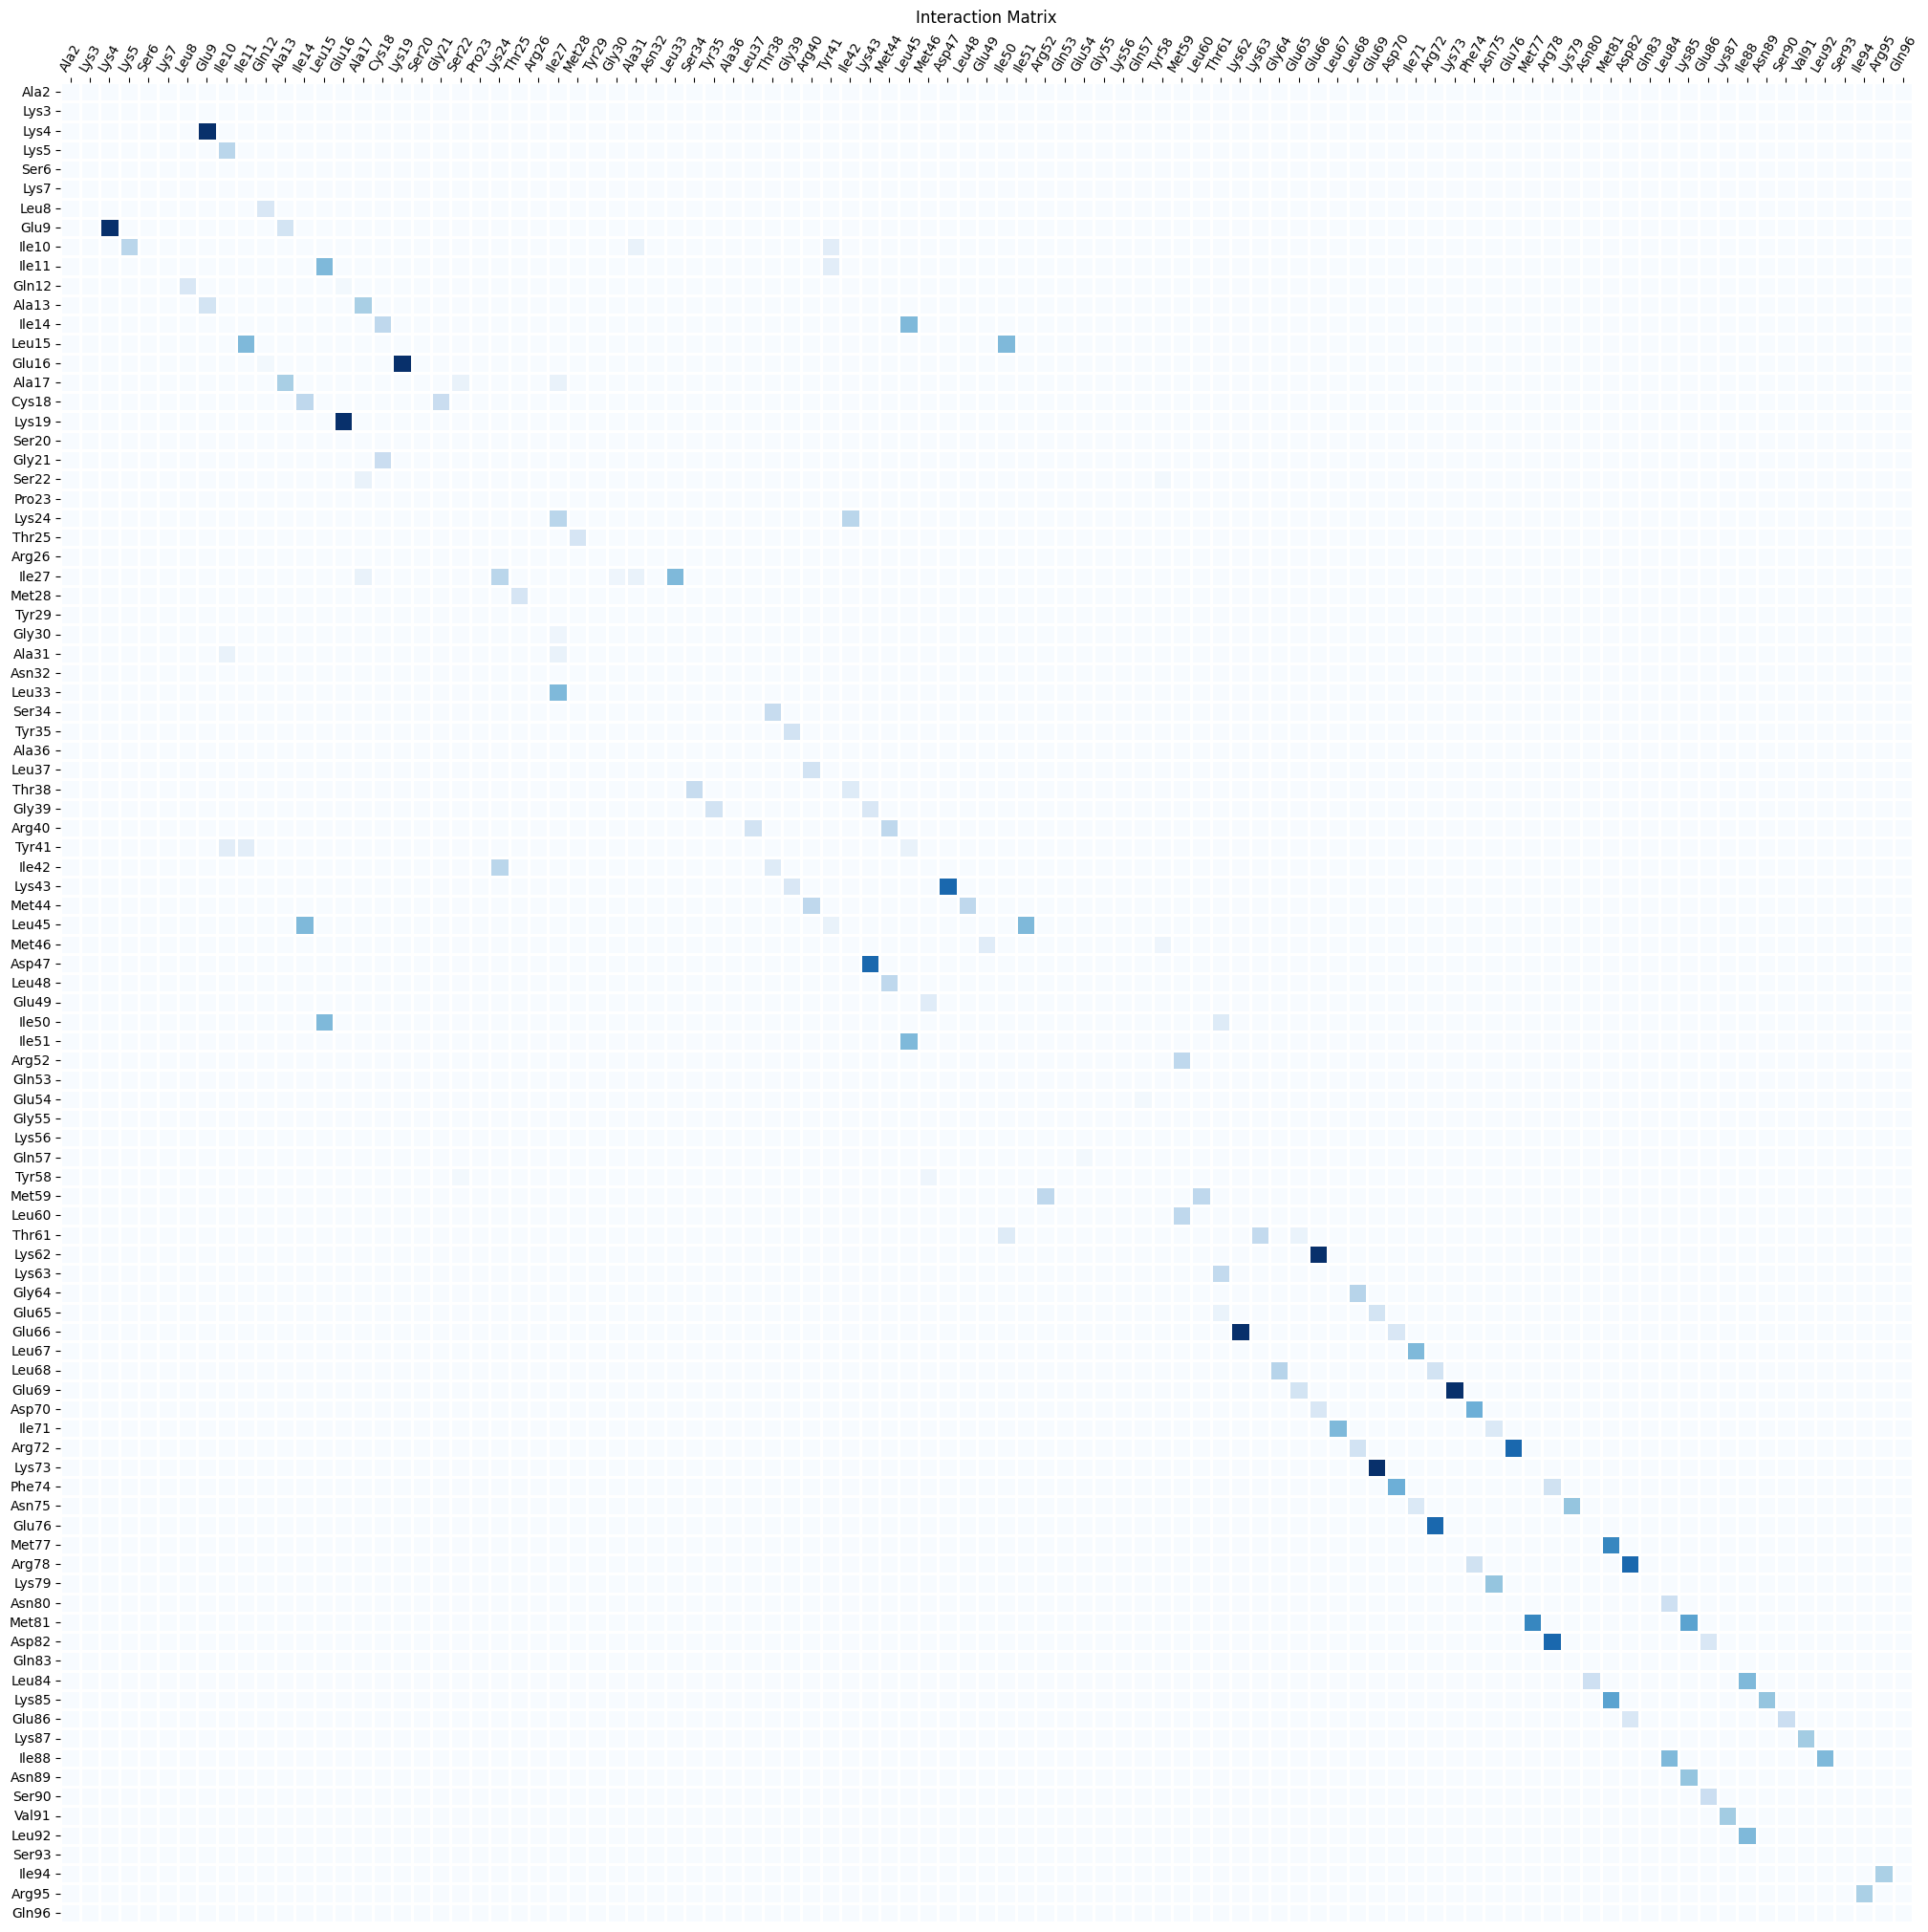

In [35]:
if protein_name == 'Sso10a':
    plt.figure(figsize=(25, 25))
    ax = sns.heatmap(
        interaction_matrix, cbar=False, xticklabels=labels[1:],
        yticklabels=labels[1:], linewidths=2, cmap="Blues"
    )  # Sso10a has only experiment data for residues 2-96
else:
    plt.figure(figsize=(12, 12))
    ax = sns.heatmap(
        interaction_matrix, cbar=False, xticklabels=labels,
        yticklabels=labels, linewidths=2, cmap="Blues"
    )
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
if protein_name == 'Sso10a':
    ax.tick_params(axis='x', rotation=60)  # only for Sso10a
else:
    ax.tick_params(axis='x', rotation=45)  # for the rest
ax.set_title("Interaction Matrix")

## Pearson Correlation Coefficient


In [36]:
# Sso10a has only experiment data for residues 2-96
if protein_name == "Sso10a":
    ig_importances = ig_importances[1:, 1:]

In [37]:
pearson_corr = pearsonr(interaction_matrix.flatten(), ig_importances.flatten())
print(f"Pearson Correlation Coefficient: {pearson_corr.statistic}")

Pearson Correlation Coefficient: -0.0025633532336669807


## Spearman Correlation Coefficient


In [38]:
spearman_corr = spearmanr(interaction_matrix.flatten(),
                          ig_importances.flatten())
print(f"Spearman Correlation Coefficient: {spearman_corr.statistic}")

Spearman Correlation Coefficient: 0.016252610923737223


: 